In [4]:
# Import libraries
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("*********   Loaded library     ***********")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [2]:
pip install bs4

     |████████████████████████████████| 122kB 18.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


### Credentials and Core location¶

In [75]:
CLIENT_ID = 'Q0TW3RYWNNWM5N34WZV520E2WORRZXAE2ESDSIPVVIMHPC3N' # your Foursquare ID
CLIENT_SECRET = 'JCB5FLJLZIV55W3I0OCTL3VOIVKDWWCSM3TUOUMOEVZRSO5E' # your Foursquare Secret
VERSION = '20191028'
LIMIT = 150

address = "Kanyakumari, Tamil Nadu"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

kan='Kanyakumari, Tamil Nadu : {},{}'.format(latitude,longitude)
print(kan)

Kanyakumari, Tamil Nadu : 8.079252,77.5499338


Search for hotel & restaurant within 1 KM

In [76]:
#Quering for hotel & restaurant

search_query = 'hotel'
search_query_res = 'restaurant'

radius = 1000
url_hotel = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/5a17c667f96b2c105e79a65e?client_id=Q0TW3RYWNNWM5N34WZV520E2WORRZXAE2ESDSIPVVIMHPC3N&client_secret=JCB5FLJLZIV55W3I0OCTL3VOIVKDWWCSM3TUOUMOEVZRSO5E&v=20191028'

Send the GET Request of hotel & restaurants and examine the results¶

In [77]:
results_hotel = requests.get(url_hotel).json()
results_restaurant = requests.get(url_restaurant).json()
#results_hotel

Get relevant part of JSON and transform it into a pandas dataframe

In [78]:
# assign relevant part of JSON to venues
venues_hotel = results_hotel['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_hotel = json_normalize(venues_hotel)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_hotel,dataframe_restaurant])

print("There are {} restaurants and hotels at Kanyakumari, Tamil Nadu".format(dataframe.shape[0]))

There are 38 restaurants and hotels at Kanyakumari, Tamil Nadu


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys


Define information of interest and filter dataframe

In [79]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
hotels_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
hotels_df.head()

,name,categories,distance,lat,lng,id
0,Hotel SeaView,Hotel,371,8.082333,77.551217,4cd42e2c558a370412d0c5a6
1,Hotel Sarvana,Hotel,179,8.080581,77.550861,4db052544df03036e8b9d615
2,Hotel Samudra,Motel,201,8.080642,77.551102,4d3c66e414aa8cfa4641a95e
3,Hotel Annapoorna,Indian Restaurant,206,8.080879,77.550835,50ed3a39e4b0ac50005eb3f1
4,Hotel Trisea,South Indian Restaurant,269,8.081475,77.548969,5030a43ee4b021f7a59c7456


location of hotels

In [80]:
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=16) 
# generate map centred around the Kanyakumari

# add a red circle marker to represent the core location of kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Cleveland',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)

# add the restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

In [81]:
dataframe_filtered=dataframe_filtered.drop(dataframe_filtered[dataframe_filtered.name =='Hotel Bharani'].index)
hotels_df=dataframe_filtered
print("So Now there are {} hotels & restaurants present in Kanyakumari, Tamil Nadu".format(dataframe_filtered.shape[0]))

So Now there are 37 hotels & restaurants present in Kanyakumari, Tamil Nadu


How Far are hotels from the core location

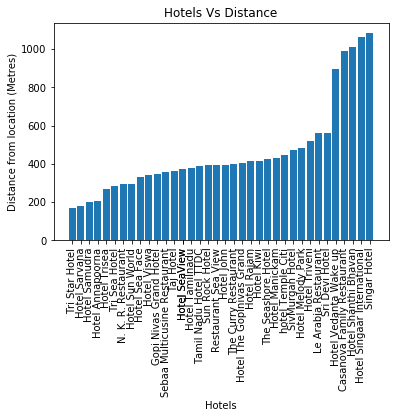

Average distance between hotels and core location is 457 metres


In [82]:
distance_hotel_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_hotel_df.name))
    plt.bar(distance_hotel_df.name, distance_hotel_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_hotel_df.name,rotation=90)
    plt.title('Hotels Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between hotels and core location is {} metres".format(int(sum(hotels_df['distance'])/hotels_df.shape[0])))


Explore for other venues around Kanyakumari

In [83]:
radius=1000
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url_venues

In [84]:
import requests

results_venues = requests.get(url_venues).json()
'There are {} venues around Cleveland.'.format(len(results_venues['response']['groups'][0]['items']))

'There are 17 venues around Cleveland.'

Get relevant part of JSON and transform it into a pandas dataframe

In [85]:
items_venues = results_venues['response']['groups'][0]['items']
items_venues[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4f21fd64e4b0717a65eeddc3',
  'name': 'Sunrise Point',
  'location': {'lat': 8.079398442658686,
   'lng': 77.55115801596587,
   'labeledLatLngs': [{'label': 'display',
     'lat': 8.079398442658686,
     'lng': 77.55115801596587}],
   'distance': 135,
   'cc': 'IN',
   'city': 'Kanniyākumāri',
   'state': 'Tamil Nadu',
   'country': 'India',
   'formattedAddress': ['Kanniyākumāri', 'Tamil Nadu', 'India']},
  'categories': [{'id': '4bf58dd8d48988d1e2941735',
    'name': 'Beach',
    'pluralName': 'Beaches',
    'shortName': 'Beach',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4f21fd64e4b0717a65eeddc3-0'}

In [86]:
dataframe_venues = json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues.name

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


0                 Sunrise Point
1     Vivekananda Rock Memorial
2               End of the Land
3             Kanyakumari Beach
4                Triveni Sangam
5        Sparsa Resorts and Spa
6                 Hotel SeaView
7             Sangam Restautant
8               Gandhi Memorial
9                 Hotel Sarvana
10         Thiruvalluvar Statue
11                   Ferry Boat
12     Watch Tower, Kanyakumari
13       Kanyakumari Lighthouse
14           The Seashore Hotel
15     Kanyakumari Bus Stantion
16       Thiruvalluvar Mandapam
Name: name, dtype: object

Extract Venues using Search Queries

In [87]:
# search query function
search_query_list = ['church','park','museum'] 
radius =1000
temp_df=[]
search_df=[]

def search_query_fn():   
    #Loop to run through urls and from json to pandas
    for i in range(len(search_query_list)):
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_list[i], radius, LIMIT)
        
        results=requests.get(url).json()
        venues = results['response']['venues']
        
        #Normalize from json
        dataframe = json_normalize(venues)
        
        #Removing unwanted column headers
        dataframe.columns = [col.split('.')[-1] for col in dataframe.columns]
        temp_df.append(dataframe)
    
    #Loop to append dataframes to single dataframe
    for j in range(len(search_query_list)):
        data=temp_df[j]
        search_df.append(data)

# Function to run loop over queries
search_query_fn()

search_df = pd.concat(search_df,sort=True)
search_df['categories'] = search_df.apply(get_category_type, axis=1)
search_df = pd.DataFrame(search_df[['name','categories','distance','lat','lng','id']])
search_df

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,distance,lat,lng,id
0,St.Anthony's Church,Church,435,8.082916,77.551320,4db2dc880437fa536a056d3e
1,Our Lady Of Ransom Church,Church,680,8.085158,77.551544,4edb6b300e011b46ef9c3af5
0,Triangle Park,Park,8,8.079332,77.549930,5a17c667f96b2c105e79a65e
1,Hotel Melody Park,Hotel,482,8.083571,77.549568,52fbace0498e429e952167c7


In [88]:
# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=pd.concat([four_sq_venue, new_venues],sort=True)

In [89]:
to_drop = ['Hotel', 'Restautant','hotel','Resort']
df_venues = df_venue[~df_venue['name'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in kanyakumari".format(df_venues.shape[0]))
df_venues[['name','distance','id']]

There are 15 venues in kanyakumari


,name,distance,id
0,Sunrise Point,135,4f21fd64e4b0717a65eeddc3
1,Vivekananda Rock Memorial,312,4b9cbc7ef964a520e37836e3
2,End of the Land,148,4f22babfe4b0ed339695e61e
3,Kanyakumari Beach,10,4e8d9f944fc653e47d1afef1
4,Triveni Sangam,277,4eb57ae40cd688257829927c
5,Gandhi Memorial,26,4e8d8fc94fc653e47d19524a
6,Thiruvalluvar Statue,147,4ed9ed9530f83fb79c10cd14
7,Ferry Boat,259,4c71df7857b6a1436f4ec4cc
8,"Watch Tower, Kanyakumari",281,4ce8e6589f776ea8dbf96022
9,Kanyakumari Lighthouse,417,4c711c4334443704e6f5255f


In [ ]:
Location of all venues

In [90]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='kanyakumari',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        #popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

How far are venues from the core location?¶

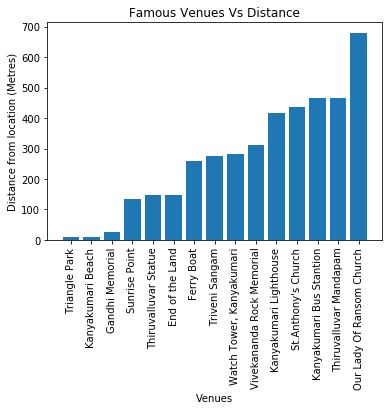

In [91]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()

Venue Categories

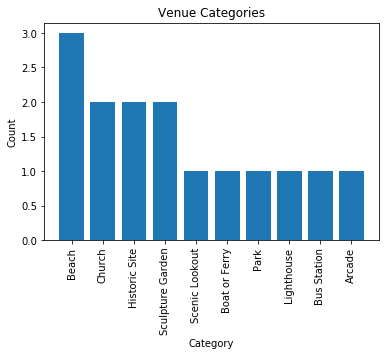

In [92]:
freq_venue=df_venues['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()

Rating of all Venues

In [93]:
#Rating of venues
rating_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)

In [28]:
rate_dict = {'Venue': df_venues.name, 'Rating': rating_df,'distance':df_venues.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

,Venue,Rating,distance
0,Sunrise Point,8,135
1,Vivekananda Rock Memorial,8.1,312
2,End of the Land,7.5,148
3,Kanyakumari Beach,7.2,10
4,Triveni Sangam,7,277
5,Gandhi Memorial,5.6,26
6,Thiruvalluvar Statue,No Rating Yet,147
7,Ferry Boat,No Rating Yet,259
8,"Watch Tower, Kanyakumari",No Rating Yet,281
9,Kanyakumari Lighthouse,No Rating Yet,417


Number of Tips for all Venues

In [29]:
tips_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    
    #print(result['response']['venue']['tips']['count'],result['response']['venue'])
    tips=result['response']['venue']['tips']['count']
    tips_df.append(tips)

In [30]:
tips_dict = {'Venue': df_venues.name, 'Tips': tips_df,'distance':df_venues.distance}
tips=pd.DataFrame(tips_dict)
tips=tips.sort_values('Tips',ascending = False)
tips

,Venue,Tips,distance
1,Vivekananda Rock Memorial,16,312
0,Sunrise Point,4,135
7,Ferry Boat,4,259
3,Kanyakumari Beach,3,10
2,End of the Land,2,148
5,Gandhi Memorial,2,26
8,"Watch Tower, Kanyakumari",1,281
10,Kanyakumari Bus Stantion,1,465
9,Kanyakumari Lighthouse,1,417
4,Triveni Sangam,1,277


Extracting Rated and Tips Venues

In [31]:
# Add Tips column to Rating Dataframe
rate_df['Tips']=tips['Tips']

#Lets take values of only rated venues
only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet') | (rate_df['Tips']!=0)]

only_rated_tips.reset_index(inplace = True,drop = True) 
only_rated_tips

,Venue,Rating,distance,Tips
0,Sunrise Point,8,135,4
1,Vivekananda Rock Memorial,8.1,312,16
2,End of the Land,7.5,148,2
3,Kanyakumari Beach,7.2,10,3
4,Triveni Sangam,7,277,1
5,Gandhi Memorial,5.6,26,2
6,Ferry Boat,No Rating Yet,259,4
7,"Watch Tower, Kanyakumari",No Rating Yet,281,1
8,Kanyakumari Lighthouse,No Rating Yet,417,1
9,Kanyakumari Bus Stantion,No Rating Yet,465,1


Final list of Venues

In [32]:
rated_list=[]
for i in range(len(only_rated_tips)):
    rated_tip_temp=only_rated_tips['Venue'][i]
    rated_list.append(rated_tip_temp)

#Masking all values present in list
mask = df_venues['name'].isin(rated_list)

final_venues = df_venues[mask]
#final_venues['location']=final_venues['lat'].astype(str).str.cat(final_venues['lng'].astype(str), sep=' - ')
final_venues.reset_index(inplace = True,drop = True) 

final_venues

,index,categories,distance,id,lat,lng,name
0,0,Beach,135,4f21fd64e4b0717a65eeddc3,8.079398,77.551158,Sunrise Point
1,1,Sculpture Garden,312,4b9cbc7ef964a520e37836e3,8.080707,77.552362,Vivekananda Rock Memorial
2,2,Arcade,148,4f22babfe4b0ed339695e61e,8.078479,77.551035,End of the Land
3,3,Beach,10,4e8d9f944fc653e47d1afef1,8.079311,77.550005,Kanyakumari Beach
4,4,Historic Site,277,4eb57ae40cd688257829927c,8.078860,77.547448,Triveni Sangam
5,8,Historic Site,26,4e8d8fc94fc653e47d19524a,8.079021,77.549976,Gandhi Memorial
6,11,Boat or Ferry,259,4c71df7857b6a1436f4ec4cc,8.080931,77.551561,Ferry Boat
7,12,Beach,281,4ce8e6589f776ea8dbf96022,8.079731,77.547430,"Watch Tower, Kanyakumari"
8,13,Lighthouse,417,4c711c4334443704e6f5255f,8.081389,77.546820,Kanyakumari Lighthouse
9,15,Bus Station,465,4edc1b4846907c1b44ba0ed8,8.082652,77.547469,Kanyakumari Bus Stantion


Clustering based on venues

In [33]:
# one hot encoding
neighbor_onehot = pd.get_dummies(final_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = final_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,Arcade,Beach,Boat or Ferry,Bus Station,Historic Site,Lighthouse,Sculpture Garden
0,Sunrise Point,0,1,0,0,0,0,0
1,Vivekananda Rock Memorial,0,0,0,0,0,0,1
2,End of the Land,1,0,0,0,0,0,0
3,Kanyakumari Beach,0,1,0,0,0,0,0
4,Triveni Sangam,0,0,0,0,1,0,0


In [34]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [35]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [36]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clustersss', kmeans.labels_)

neighbor_merged = final_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

Center of all clusters & Midpoint of all venues
We will be collating the location of centroid of all clusters and midpoint of all venues to get more accurate location

In [37]:
fin=neighbor_merged.groupby(['Clustersss']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(final_venues.lat)/len(final_venues.lat)
venues_lng=sum(final_venues.lng)/len(final_venues.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new hotel:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of our brand new hotel:8.079899388854393,77.54944512303567


In [38]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

In [98]:
my_hotel_vs_all = folium.Map(location=[latitude, longitude], zoom_start=16) 
# generate map centred around the Kanyakumari
# add a red circle marker to represent the my hotel location
folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My Hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)


# add a red circle marker to represent the core location of kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Kanyakumari',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)


    



# display map
my_hotel_vs_all

# Results section

###  My hotel location

Final location is pointed at 8.07985,77.54973

This location is at Beach Road opposite to Gandhi Memorial and Kumari Temple.

Located at exact junction of two cross roads which can give more attention to people who passby.

### Top Rated Venues

Sunrise Point
Vivekananda Rock Memorial
End of the Land
Kanyakumari Beach
Triveni Sangam
Gandhi Memorial

# Discussion section

From above reports,we could get an idea why the predicted one is pointed/clustered on the given spot.First most thing could be the center of attraction for the place.

KMeans have figured out the most common place for all the venues.This output was very adjacent to the core location.This proves the accurate spotting of our predicted algorithm.

Despite of the findings,there were some lack in data.Tips and ratings were missing for most of the venues.Also when I compared foursquare data with google map ,i could see there were many hotels and venues found missing in foursquare.

# Conclusion section

As a business person,one would be able to set up a hotel/restaurant on given spot.This will bring revenue automatically as we have located in very near to core one.We proved this with Kmeans.